# Stokes coefficients estimation
In this set of notebooks, we show simulations of retrival of a set of real spherical harmonics gravity coefficients from a set of gravitational measurements (either potential or acceleration). This is a simplified example of what is performed in an orbit determination (OD) campaign, where the Stokes coefficients are estimated, along with other parameters, from a set of radio-tracking measurements of an orbiting spacecraft.

## **Case 4**: Fitting Bennu particle accelerations
Here we use synthetic accelerations computed for particles in orbit around asteroid Bennu using the polyhedron method. Therefore, here the synthetic data are not generated using spherical harmonics. We then compare the estimated Stokes coefficients with those corresponding to the polyhedral mesh

In [3]:
import os
import numpy as np
import pyshtools as sh
import matplotlib.pyplot as plt

import spherical_inr as sph
import spherical_inr.differentiation as D
import torch
import pickle as pk

import scripts
from scripts._units import *

### Settings

In [4]:
out_name = "bennu_particles" # outputs destination folder (a subfolder of out)
out_path = os.path.join("out", out_name)
if not os.path.exists(out_path):
    os.makedirs(out_path)

In [24]:
partials_func = scripts.acc_cnm_partials 
rng = np.random.default_rng()

### Ground-truth gravity
In this case, the reference Stokes coefficients are computed for the polyhedral mesh representing the shape of asteroid Bennu, using our GILA tool and assuming a homogeneous density distribution of $1200 kg/m^3$. By tracking particles orbiting the asteroids (whose trajectories are used below), the OSIRIS-REx team obtained a SH gravity field up to degree 10. Therefore, here we choose to also estimate a set of Stokes coefficients with `n_max_est=10`.
The coefficients in `cnm_mat_sim` are not used to generate the synthetic measurements (which have been computed separately and are only loaded here). They only provide the ground truth.

In [15]:
L_gt = 10 # macimum degree of the coefficients used to simulate the measurements
L_est = 10 # maximum degree of the coefficients to be estimated

# Read SH coefficients, and cut to L_gt
file_name = "spice/data/bennu/sh_homogeneous.json"
coeffs, r_0, gm = scripts.read_cnm_json(file_name)
cnm_gt = coeffs[:, : L_gt + 1, : L_gt + 1]

# Index array and dictionary to go from a matrix of Cnm to a 1D array, and vice-versa
cnm_idx_sim, cnm_map_sim = scripts.get_cnm_idx(L_gt)
cnm_idx_est, cnm_map_est = scripts.get_cnm_idx(L_est)

### Measurements points
The locations of the measurements are obtained from the SPICE kernels of the tracked particles in orbit around Bennu, which are provided by the OSIRIS-REx team. These particles constitute rubble material escaping from the surface of the asteroid. Given their abundance and the low altitudes of their orbits, tracking these particles allowed to greatly improve the resolution of the estimated gravity, which aws around degree-4 using spacecraft radio-tracking alone. This specific example and irregular bodies in general are particularly challenging for the gravity representation via spherical harmonics, due to the very localized variations in the field and the divergence effects close to the surface.
In this simulation, given the orbits of selected particles and a polyhedral shape model for Bennu, we use the ESA polyhedral-gravity library to generate synthetic gravity accelerations at points along the trajectories, with a time-step of 300 seconds. Again, these measurements 

### Training & Testing Data

In [28]:
file_path = "spice/data/bennu/particles_grav.pkl"
with open(file_path, "rb") as f:
    xyz_coords_train, sph_coords_train, acc_train = pk.load(f)

In [29]:
xyz_coords_test, sph_coords_test = scripts.points_from_grid(L_gt, r=(r_0 * 1.1), use_GLQ_grid=True)

In [30]:
pot_test, acc_test = [
    el * gm for el in scripts.compute_pot_acc(cnm_gt, r_0, sph_coords_test)
]

100%|██████████| 11/11 [00:00<00:00, 3663.15it/s]


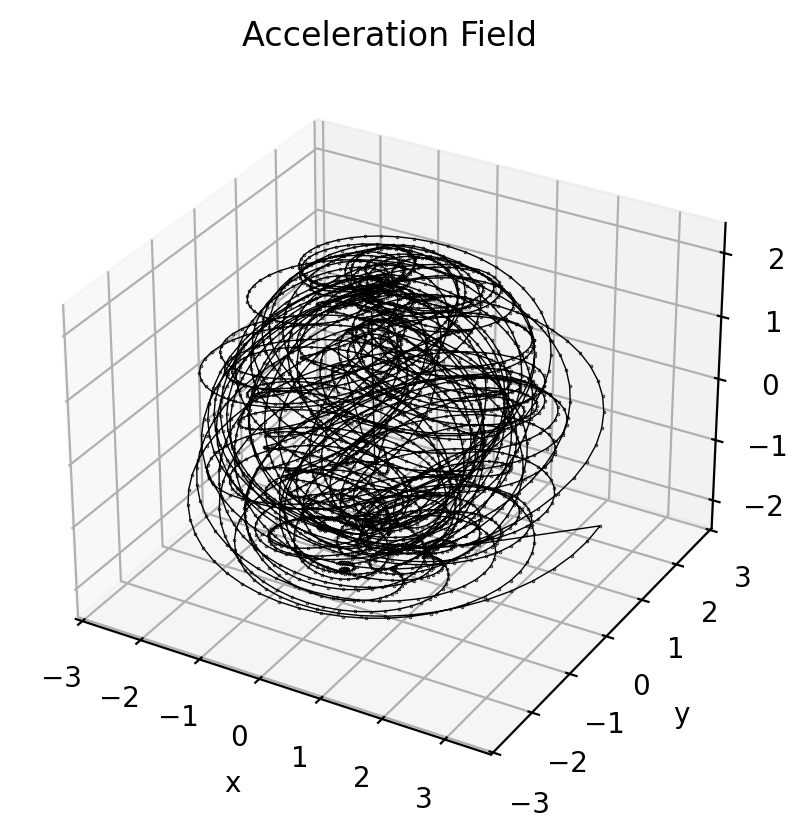

In [50]:
r   = sph_coords_train[:, 0]
th  = sph_coords_train[:, 1]  # colatitude in radians
phi = sph_coords_train[:, 2]

x = r * np.sin(th) * np.cos(phi)
y = r * np.sin(th) * np.sin(phi)
z = r * np.cos(th)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

sc = ax.plot(
    x/r_0, y/r_0, z/r_0, color = "k", lw = .5, marker = ".", markersize = 0.5
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Acceleration Field")

plt.show()



In [ ]:
errors = (pot_test - pot_pred)
rel_errors = errors / pot_test

error_stats = [
    np.mean(errors),
    np.median(errors),
    np.linalg.norm(errors) / np.sqrt(errors.size),
]
error_stats.append(np.log10(np.abs(np.mean(1 / (rel_errors + 1e-20)))))

print("Error stats: ")
print("Mean: {:.5g} - Median: {:.5g} -  RMS: {:.5g} - SNR (dB):{:.5g}".format(*error_stats))

Error stats: 
Mean: 0.00053443 - Median: 5.1795e-05 -  RMS: 0.0027147 - SNR (dB):10.626


In [ ]:
errors = (pot_test - pot_pred)
rel_errors = errors / pot_test

error_stats = [
    np.mean(errors),
    np.median(errors),
    np.linalg.norm(errors) / np.sqrt(errors.size),
]
error_stats.append(np.log10(np.abs(np.mean(1 / (rel_errors + 1e-20)))))

print("Error stats: ")
print("Mean: {:.5g} - Median: {:.5g} -  RMS: {:.5g} - SNR (dB):{:.5g}".format(*error_stats))

Error stats: 
Mean: 0.00053443 - Median: 5.1795e-05 -  RMS: 0.0027147 - SNR (dB):10.626


## Forward model

### Computing partials
The partial computation and the filtering are performed in the same way as in the previous notebook

In [31]:
dim = 3 # dimension of the measurements
N_coords = acc_train.shape[0]

cnm_est_mat = np.empty((2, L_est + 1, L_est + 1), dtype=bool)
noise = 1e-4 * gm / np.pow(r_0, 2)

In [32]:
N_mat, y, _ = scripts.compute_normal_equations(
    cnm_mat = cnm_est_mat,
    sph_coords = sph_coords_train,
    partials_func=partials_func,
    r_0 = r_0,
    batch_size=1000,
    msr_noise = noise,
    partials_scale=gm,
    raw_msr_vec=acc_train.reshape(N_coords * dim), 
    perturb_msr=False ,
    rng=rng
)

100%|██████████| 5/5 [00:00<00:00, 128.78it/s]


### Least-squares solution

In [33]:
cnm_est, _ = scripts.solve_normal_equations(
    N_mat= N_mat, 
    y = y, 
    compute_covariance=False
)

cnm_est_mat = cnm_est_mat.astype(np.double)
cnm_est_mat[*cnm_idx_est.T] = cnm_est

Solving via lstsq...
Took 0.00 s


### Prediction

In [34]:
pot_pred, acc_pred = [
    el * gm for el in scripts.compute_pot_acc(cnm_est_mat, r_0, sph_coords_test)
]

100%|██████████| 11/11 [00:00<00:00, 2922.49it/s]


### Storing results

In [35]:
cnm_sol_file = "cnm_estimated"
scripts.write_SHADR(
    os.path.join(out_path, cnm_sol_file + ".txt"),
    cnm_est,
    cnm_map_est,
    gm=gm,
    r_0=r_0,
)

# Saving measurements evaluated on a spherical grid
grid_train_file = "acc_train"
scripts.save_msr_grid(
    os.path.join(out_path, grid_train_file + ".pkl"),
    sph_coords_train,
    acc_train,
)

grid_gt_file = "pot_test"
scripts.save_msr_grid(
    os.path.join(out_path, grid_gt_file + ".pkl"),
    sph_coords_test,
    pot_test,
)

grid_est_file = "pot_pred"
scripts.save_msr_grid(
    os.path.join(out_path, grid_est_file + ".pkl"),
    sph_coords_test,
    pot_pred,
)

### Retrieve

In [36]:
grid_train_file = "acc_train"
sph_coords_train, acc_train = scripts.read_msr_grid(
    os.path.join(out_path, grid_train_file + ".pkl")
)

grid_gt_file = "pot_test"
sph_coords_test, pot_test = scripts.read_msr_grid(
    os.path.join(out_path, grid_gt_file + ".pkl")
)

grid_est_file = "pot_pred"
sph_coords_test, pot_pred = scripts.read_msr_grid(
    os.path.join(out_path, grid_est_file + ".pkl")
)

### Error

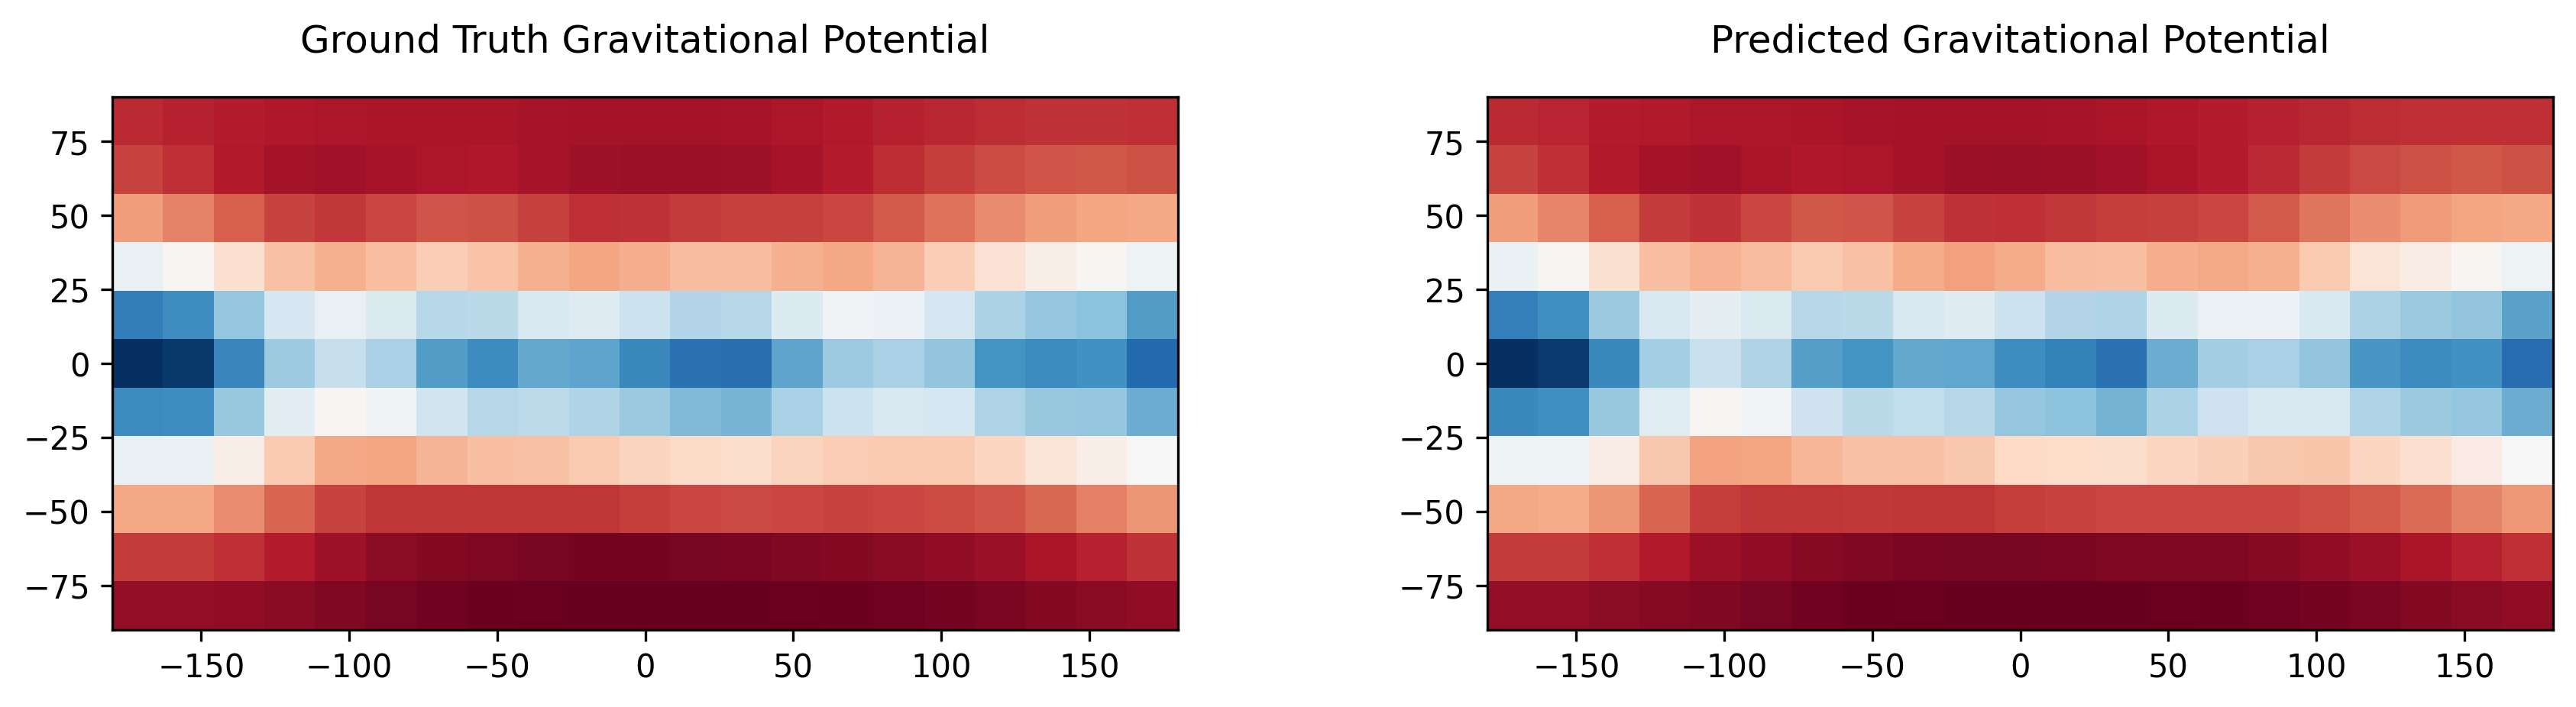

In [38]:
data_test = pot_test.reshape(L_gt+1, 2*(L_gt+1) - 1)
data_pred = pot_pred.reshape(L_gt+1, 2*(L_gt+1) - 1)


fig = plt.figure(figsize=(12, 12), dpi = 300)
subfigs = fig.subfigures(1, 2)

scripts.plot_sphere(data_test,   fig= subfigs[0], cmap = "RdBu", title="Ground Truth Gravitational Potential")
scripts.plot_sphere(data_pred,   fig= subfigs[1], cmap = "RdBu", title="Predicted Gravitational Potential")
plt.show()

In [51]:
errors = (pot_test - pot_pred)
rel_errors = errors / pot_test

error_stats = [
    np.mean(errors),
    np.median(errors),
    np.linalg.norm(errors) / np.sqrt(errors.size),
]
error_stats.append(np.log10(np.abs(np.mean(1 / (rel_errors + 1e-20)))))

print("Error stats: ")
print("Mean: {:.5g} - Median: {:.5g} -  RMS: {:.5g} - SNR (dB):{:.5g}".format(*error_stats))

Error stats: 
Mean: 2.8678e-08 - Median: -3.8856e-09 -  RMS: 5.027e-06 - SNR (dB):4.2829


## HNET

In [52]:
model_path = os.path.join("models", out_name)
if not os.path.exists(model_path):
    os.makedirs(model_path)

### Data Preprocessing

We define some reference value for the radius, potential and acceleration to later un-dimensionalize them. 

In [56]:
r_star =r_0
u_star = gm / r_star
a_star = u_star / r_star

print(
    f"u_star = {u_star} [m^2/s^2]",
    f"r_star = {r_star} [m]",
    f"a_star = {a_star} [m/s^2]",
    sep="\n"
)

u_star = 0.017230133310113277 [m^2/s^2]
r_star = 286.62249755859375 [m]
a_star = 6.011437851835392e-05 [m/s^2]


Deep Learning model needs to work with scaled data

In [57]:
acc_train_scaled = acc_train.copy() / a_star

pot_test_scaled = pot_test.copy().reshape(-1, 1) / u_star

sph_coords_train_scaled = sph_coords_train.copy()
sph_coords_train_scaled[:, 0] /= r_star

sph_coords_test_scaled = sph_coords_test.copy()
sph_coords_test_scaled[:, 0] /= r_star

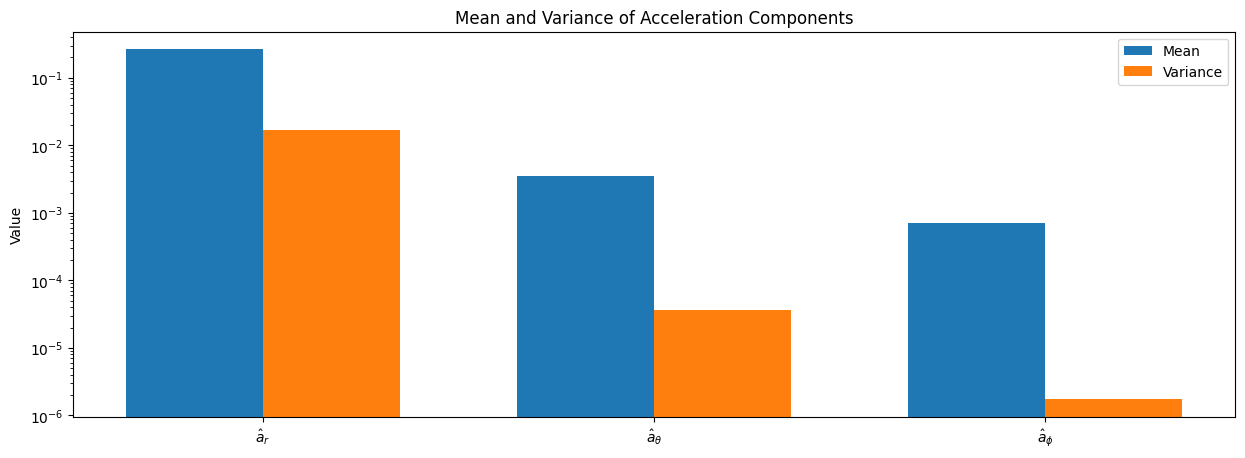

In [58]:
# Compute mean and variance for each component of the acceleration (spherical frame)
mean_vals = np.mean(np.abs(acc_train_scaled), axis=0)
var_vals = np.var(acc_train_scaled, axis=0)
labels_acc = [r'$\hat{a}_{r}$', r'$\hat{a}_{\theta}$', r'$\hat{a}_{\phi}$']

fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))


x = np.arange(len(labels_acc))
width = 0.35  # width of the bars

ax1.bar(x - width/2, mean_vals, width, label='Mean')
ax1.bar(x + width/2, var_vals, width, label='Variance')
ax1.set_ylabel('Value')
ax1.set_title('Mean and Variance of Acceleration Components')
ax1.set_xticks(x)
ax1.set_xticklabels(labels_acc)
ax1.legend()
ax1.set_yscale('log')

plt.show()

In [59]:
xtrain = torch.tensor(sph_coords_train_scaled.copy(), dtype=torch.float32).requires_grad_(True)
ytrain = torch.tensor(acc_train_scaled.copy(), dtype=torch.float32)

xtest = torch.tensor(sph_coords_test_scaled.copy(), dtype=torch.float32)
ytest = torch.tensor(pot_test_scaled.copy(), dtype=torch.float32)

In [184]:
def gen_random_s2(n : int):
    v = torch.randn(n, 3)
    v /= torch.norm(v, dim=1).reshape(-1, 1)
    r = torch.tensor(20.0*np.random.uniform(.1, 1, n)**(1/3), dtype=torch.float32)
    
    
    theta = torch.acos(v[:, 2])
    phi = torch.atan2(v[:, 1], v[:, 0])
    v = torch.stack((r, theta, phi), dim=1)
    return v

### Model

In [185]:
class ModifiedHHNET(sph.INR):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rref = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x= sph.transforms.rsph2_to_cart3(x)
        x = self.pe(x/self.rref)
        x = self.mlp(x)
        return x
        

hnet= ModifiedHHNET(
    input_dim=3,
    output_dim = 1, 
    inr_sizes = [100] + 2*[100],
    pe = "irregular_herglotz",
    activation = "sin",
    pe_kwards = {"omega0": 5},
    bias= False,  
)

### Loss

In [180]:
def loss_modified(target, output, input, alpha_t = 1e2, alpha_p = 1e3):
    
    ddr, ddt, ddp = D.spherical_gradient(output, input, track=True).unbind(-1)
    target_r, target_t, target_p = target.unbind(-1)
    scale = target_r.abs()
    loss = torch.nn.functional.mse_loss(ddr/scale, target_r/scale) + alpha_t * torch.nn.functional.mse_loss(ddt, target_t) + alpha_p*torch.nn.functional.mse_loss(ddp, target_p)

    return loss

In [181]:
Reg = sph.SphericalLaplacianLoss()
MSE = torch.nn.MSELoss()

def loss_fn(target, output, input, yreg, xreg):
    return loss_modified(target, output, input) +  1e1*Reg(yreg, xreg)
    

### Training

In [182]:
epoch = 2500
batch_size = 2048
lr = 1e-3
optimizer = torch.optim.Adam(hnet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)

In [ ]:
dataset = torch.utils.data.TensorDataset(xtrain, ytrain)
dataloader =torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

hnet.train()
for ep in range(epoch):
    epoch_loss = 0.0
    xreg = gen_random_s2(10000).requires_grad_(True)
    for xb, yb in dataloader:
        optimizer.zero_grad()
        ypred = hnet(xb)
        yreg = hnet(xreg)
        loss = loss_fn(yb, ypred, xb, yreg, xreg)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    hnet.eval()
    with torch.no_grad():
        ytest_pred = hnet(xtest)
        val_loss = MSE(ytest_pred, ytest) ** 0.5
    hnet.train()
    
    if ep % 5 == 0:
        print(f"Epoch {ep} Loss {epoch_loss**0.5} Val Loss {val_loss.item()}", end = "\r")

In [ ]:
torch.save(hnet.state_dict(), model_path + "/ghet.pth")

In [ ]:
hnet.load_state_dict(torch.load(model_path + "/ghet.pth"))
hnet.eval()

ModifiedHHNET(
  (pe): IregularHerglotzPE(num_atoms=200, input_dim=3, omega0=1.0, omega0=1.0)
  (mlp): MLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1-2): 2 x Linear(in_features=100, out_features=100, bias=False)
      (3): Linear(in_features=100, out_features=1, bias=False)
    )
    (activation): LeakyReLU(negative_slope=0.01)
  )
)

In [ ]:
def U(x):
    return u_star * (hnet(x).squeeze().detach().numpy())

### Errors

In [ ]:
pot_pred = U(xtest)

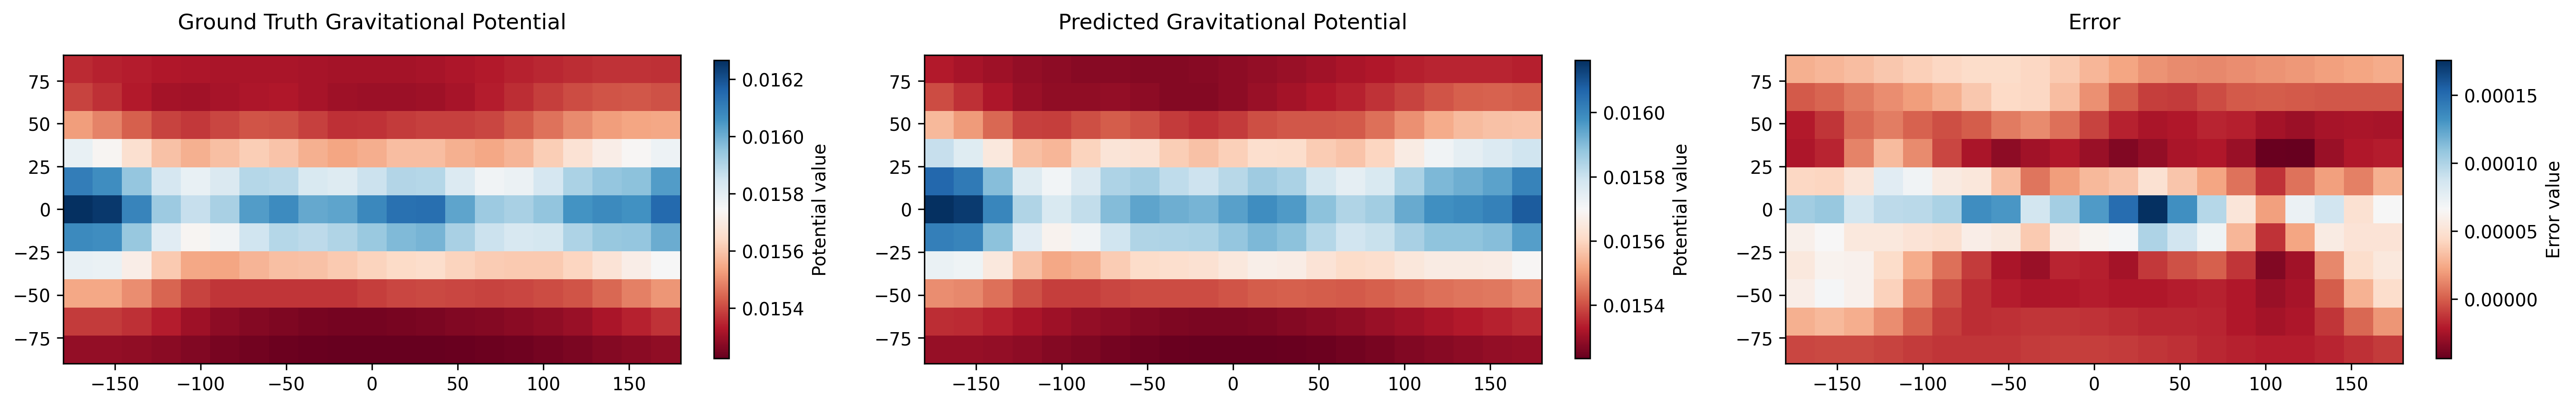

In [ ]:
# coeffs = sh.SHCoeffs.from_array(cnm_gt)
data_pred = pot_pred.reshape(  (L_gt+1, 2*(L_gt+1) - 1))
data_test = pot_test.reshape( (L_gt+1, 2*(L_gt+1) - 1))

fig = plt.figure(figsize=(20, 15), dpi = 300)
subfigs = fig.subfigures(1, 3)
scripts.plot_sphere(data_test,   fig= subfigs[0], cmap = "RdBu", title="Ground Truth Gravitational Potential")
ax = subfigs[0].axes[0]
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Potential value')

scripts.plot_sphere(data_pred,   fig= subfigs[1], cmap = "RdBu", title="Predicted Gravitational Potential")
ax = subfigs[1].axes[0]
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Potential value')

scripts.plot_sphere(data_test - data_pred,   fig= subfigs[2], cmap = "RdBu", title="Error")
ax = subfigs[2].axes[0]
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.025)
cbar.ax.set_ylabel('Error value')

plt.show()

In [177]:
errors = (pot_test - pot_pred)
rel_errors = errors / pot_test

error_stats = [
    np.mean(errors),
    np.median(errors),
    np.var(errors),
    np.linalg.norm(errors) / np.sqrt(errors.size),
]
error_stats.append(np.log10(np.abs(np.mean(1 / (rel_errors + 1e-20)))))

print("Error stats: ")
print("Mean: {:.5g} - Median: {:.5g} -  Var : {:5g} - RMS: {:.5g} - SNR (dB):{:.5g}".format(*error_stats))

Error stats: 
Mean: 1.6867e-05 - Median: 6.4141e-06 -  Var : 1.61968e-09 - RMS: 4.3637e-05 - SNR (dB):3.7417
